<a href="https://colab.research.google.com/github/zafar142007/tv-advert-detection/blob/master/Adastra_simplified_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import math
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore') 

Using TensorFlow backend.


In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [0]:
file = open('./drive/My Drive/Colab Notebooks/dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
classes = 'ad non-ad'.split()
for g in classes:
    for filename in os.listdir(f'./drive/My Drive/Colab Notebooks/dataset/{g}'):
        rec = f'./drive/My Drive/Colab Notebooks/dataset/{g}/{filename}'
        y, sr = librosa.load(rec, mono=True, duration=5)
        rmse = librosa.feature.rmse(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename.replace(" ", "-")} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('./drive/My Drive/Colab Notebooks/dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [0]:
data = pd.read_csv('./drive/My Drive/Colab Notebooks/dataset.csv')
data.head()
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
#Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [0]:
#Validating our approach
x_val = X_train[:20]
partial_x_train = X_train[20:]

y_val = y_train[:20]
partial_y_train = y_train[20:]

model = Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=500,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)
#save
model_name = './drive/My Drive/Colab Notebooks/model-'+str(datetime.now()).replace(" ", "-").replace(".", "-");
model.save(model_name+'.h5')
np.save(model_name+ '_mean', scaler.mean_)
np.save(model_name+'_var', scaler.var_)
#Predictions on Test Data
predictions = model.predict(X_test)

Train on 817 samples, validate on 20 samples
Epoch 1/30
817/817 [==============================] - 0s 416us/step - loss: 0.6744 - accuracy: 0.5777 - val_loss: 0.6614 - val_accuracy: 0.6500
Epoch 2/30
817/817 [==============================] - 0s 47us/step - loss: 0.5497 - accuracy: 0.8054 - val_loss: 0.6013 - val_accuracy: 0.6500
Epoch 3/30
817/817 [==============================] - 0s 40us/step - loss: 0.4391 - accuracy: 0.8409 - val_loss: 0.5500 - val_accuracy: 0.7500
Epoch 4/30
817/817 [==============================] - 0s 40us/step - loss: 0.3594 - accuracy: 0.8617 - val_loss: 0.5559 - val_accuracy: 0.7500
Epoch 5/30
817/817 [==============================] - 0s 38us/step - loss: 0.2951 - accuracy: 0.8862 - val_loss: 0.5673 - val_accuracy: 0.8000
Epoch 6/30
817/817 [==============================] - 0s 38us/step - loss: 0.2448 - accuracy: 0.9180 - val_loss: 0.5312 - val_accuracy: 0.8000
Epoch 7/30
817/817 [==============================] - 0s 40us/step - loss: 0.2154 - accuracy: 0.

[[50  1]
 [ 2 41]]


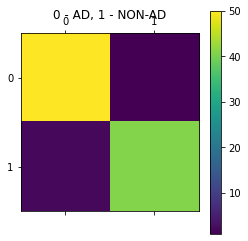

In [21]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
classes=[]
for pred in predictions:
  if pred[0]>pred[1]:
    classes.append(0)
  else:
    classes.append(1)
cm = confusion_matrix(y_test, classes)
print(cm)
np.save(model_name+ '_confusion_matrix', cm)
plt.matshow(cm)
plt.title('0 - AD, 1 - NON-AD')
plt.colorbar()
plt.savefig(model_name+'_confusion_matrix.png')
plt.show()